## ServiceX in the ATLAS integration challenge
### ML pipeline:

The final version of the integration challenge aims at providing a template for future ATLAS analyses.
This should include a ML framework that allows quick development, data preparation, training, testing and model inferencing. 

ServiceX fits perfectly in this part of the pipeline as it can fetch and transform large samples into smaller ntuples fast. 
Also, having a simpler workflow and interface compared to standard utilities (grid jobs, rucio ...) it makes it straightforward for analysts to try different samples (signals, mc_campagin, bkg data) for training/testing ML models.


One active ATLAS analysis is taking advantage of ServiceX for fetching xAOD objects from remote DAOD samples to local cached preprocessed training files as a [CLI tool](https://github.com/gordonwatts/sx_training_fetch/tree/main) 

In this notebook we will see a similar pipeline generalized to getting data from ntuples with a simple interface.  

In [ ]:
import utils 
import ml_framework.data_fetcher  
import json
import json
import gzip

###  1) Datasets metadata handle

The integration challenge also aims at providing sample management python tools to streamline the workflow.

Each analysis can organise samples in a similar way with specific categories and parameters such as rucio DIDs, n_files, n_events, MCcampagin, AMI tags, sample full size, sub-samples (ntuplizer) DIDs ... All saved into a json file 

This metadata file is produced with a tool within the IC framework by scraping the information from AMI, rucio, and Panda jobs monitoring urls.

In [ ]:
fname = "ntuple_production/file_metadata.json.gz"
with gzip.open(fname) as f:
    dataset_info = json.loads(f.read().decode())

Custom utilities to list sample categories with registered TopCP-processed outputs

These are the files most analyses use to produce training samples.

In [ ]:
samples_with_ntuples=utils.check_for_ntuples(dataset_info)

In [ ]:
print(json.dumps(samples_with_ntuples, indent = 4))

In [ ]:
total_gb = sum(v["total_output_GB"] for v in samples_with_ntuples.values())
print(f"Total size of Ntuples: {total_gb/1_000: .1f} Tb")

From the metada users can define functions to get exact lists of rucio-dids for wanted samples

In [ ]:
def build_ntuple_list(metadata: dict, categories: list[str] | str):
    if isinstance(categories, str):
        categories = [categories]
    containers={}
    
    for category in categories:
        dataset=metadata.get(category, {})
    
        for container, info in dataset.items():
            if info["output"] is None:
                continue
            did, _, campaign = utils.dsid_rtag_campaign(container)
            containers[f"{category}_{did}_{campaign}"] = "user.alheld:"+info["output"][:-1]

    return containers

Get data containers with available ntuple outputs 

In [ ]:
data_containers = build_ntuple_list(dataset_info, "data")

In [ ]:
data_containers

##### Get Ntuples for specifc backgrounds: TTbar and W + jets

In [ ]:
ntuples = build_ntuple_list(dataset_info, ["ttbar_nom", "wjets"])

In [ ]:
size_bkg = sum(samples_with_ntuples[b]["total_output_GB"] for b in ["wjets", "ttbar_nom"])
print(f"ttbar_nominal and W+jets are split into {len(ntuples)} datasets for a total of {size_bkg/1_000:.1f} TB of TopCP Ntuples")

### 2) Investigate file structure without pulling data
To prepare your ServiceX query, analyst need to know what branches are available in the targeted samples and their types. 

Levaraging ServiceX capabalities of runing custom functions on the K8s transformers the `get_structure()` allows remote file introspection.


This is a tool developped in a separate package to experiment usefull helpers but will become a feature of `servicex`



Interface to be improved - currently returning a recordArray


In [ ]:
from servicex_analysis_utils import get_structure

did=ntuples["wjets_700338_mc20e"] #chosen randomly

#Single sample example
array_structure=get_structure(did, array_out=True)
record=array_structure[did].content
print(f"{type(record)} contains 3 fields: {record.fields}")

Example: check jet pt branches (nominal and variations)

In [ ]:
#get branches from reco ttree
reco_branches = record.contents[2].fields

print(f"Total of {len(reco_branches)} branches in {did}\n")

pt_variations = [b for b in reco_branches if "jet_pt" in b] 
print(
    f"{len(pt_variations)} available jet_pt variables: \n",
    "\n ".join(pt_variations[0:5]),
)


### 3) Build query and fetch samples with the `data_fetcher` module


A wrapper arround servicex to limit boiler plate code and make it easier to use in the ML framework.
With an interface to add cuts, change branch selection, select output folder. 

It builds the `UprootRaw` query object, determines the dataset type (xRootD, Rucio, ...), the request specification (list of DIDs, sample labels) 

Some interface ideas will evolve - could be ported to the `ServiceX` package 

In [ ]:
import ml_framework.data_fetcher as fetcher

#### 3.a) Define event-level cuts on available branches:

- At least 4 jets with pT > 26 GeV

- At least one jet in the [-2.2, 2.2] eta region

- At least 2 electrons with no pT cutoff

- at least 2 electrons in the [-2.2, 2.2] eta region

- At least 2 btagged jets with the 77% WP (GN2)

In [ ]:
# Build list of awkward mask exprenssions on fields with branch names
cuts = [
    "(num(jet_pt_NOSYS[jet_pt_NOSYS > 26000]) > 3)",
    "(num(jet_eta[abs(jet_eta) < 2.2]) > 0)",
    "(num(jet_GN2v01_FixedCutBEff_77_select[jet_GN2v01_FixedCutBEff_77_select > 0]) > 1)",
    "(num(el_pt_NOSYS) > 1)",
    "(num(el_eta[abs(el_eta) < 2.2]) > 0)"
]

#### 3.b) Define the branch selection to be dumped by ServiceX workers in the result files

Branches that are read by uproot in the backend with `filter_name`

In [ ]:
branches = [
    "jet_pt_NOSYS",
    "jet_eta",
    "jet_phi",
    "jet_GN2v01_FixedCutBEff_77_select",
    "el_pt_NOSYS",
    "el_eta",
    "el_phi",
    "met_met_NOSYS",
    "met_phi_NOSYS",
    "met_significance_NOSYS",
    "met_sumet_NOSYS",
]

#### 3.c) Configure the transformation request 
- tree_name to open
- samples to get
- max number of files per sample
- output folder

Quick Example with one ttbar and one wjet sample - arbitrary

In [ ]:
# Using only 2 random samples for testing
test=["ttbar_nom_410470_mc20d", "wjets_700338_mc20e"]
samples = [ntuples[s] for s in test]

In [ ]:
# Build the RunConfig object
config = fetcher.RunConfig(
    tree_name="reco",
    dataset=samples,
    output_folder="./ml_framework/data/",
    request_name=test,
)

#### 3.d) Construct the ServiceX query object
Using `ServiceXQuery` the full UpRootRaw query and the ServiceX request specifications is constructed

In [ ]:
query = fetcher.ServiceXQuery(selection = branches, cuts = cuts, config = config)

#### 3.e) Send the query to the ServiceX transformers

Run `deliver` and parse kwargs to the `servicex.deliver()` call to get list of result files.

Other return types can be implemented in such a wrapper (e.g loaded awkard arrays, automatic file processing for specific ML tool)

In [ ]:
f=query.deliver(ignore_local_cache=True)

For reference runing the same query on all TTbar and W+jets samples (`ntuples`) took 1min30 on AF Uchicago.  

All samples are stored in MWT2 disk

Sample that took the longest to be read and transformed by workers:

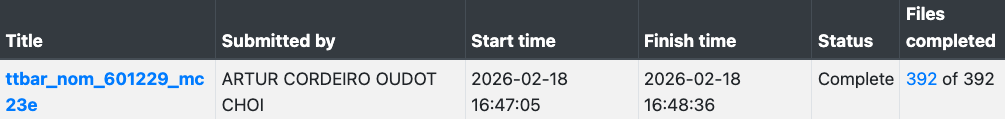

### 4) Integration with SALT-ML

Salt is a modern ATLAS ML framework (pytroch lightning-based) for configuring, training, evaluating, and saving `torch` models or converting to ONNX.

It was developped by the Flavour Tagging group and used to train important models like GN2. 

The interface is very high-level:  

Users only need to write one config file and training/evaluation is done via a CLI.

-> great for sharing work in a team, doing hyperparamter adjustments, evaluating performance in differnet samples 

#### 4.a) Preprocess the data

Salt is meant to be using `.h5` files for model inputs.

These have arrays with fixed sizes (n_events, max number of objects).

Global level (event-level) objects carry labels and sub-event-level (jets, el etc) include a `valid` label per item. 

A simple convertor was written 

In [ ]:
from ml_framework.data_preprocess import to_hdf5

In [ ]:
print(f"{f.keys()} with respectively {[len(s) for s in f.values()]} ServiceX output files")

In [ ]:
salt_file = "./ml_framework/data/ttbar_wjets.h5"
labels = [0,1]

In [ ]:
to_hdf5(files = list(f.values())[0] , labels = labels , output_file = salt_file, max_events= -1)

This convertor could become slow for large files (cannot vector copy jagged arrays into fixed-size arrays)

Not tested yet  

A data splitting utility is also added to the ml-framwork

In [ ]:
from ml_framework.data_preprocess import split_h5

In [ ]:
split_h5(salt_file, train_frac=0.7, val_frac=0.10)

#### 4.b) Build SALT model config

```yaml
ml_framework/salt-models/model-1.yaml
```

To use salt one needs to input class wieght file for each label and a normalisation file with averages and std for every input parameter. 

In [ ]:
from ml_framework.data_preprocess import make_norm_dict
make_norm_dict(salt_file, "./ml_framework/salt-models/IC-input-norms.yaml")

#### 4.b) Training models

Training is done via the CLI.

```bash
$ salt fit --config configs/model-1.yaml
$ salt test --config ... --data.test_file path/to/some/test
```

Salt uses comet as a online logger tool for any model you run using you comet API key

It allows you to keep track of every training and it saves the metrics for each ~10 epochs (configurable)
Perfect for R&D in an analysis team

Logs and metrics accessible with the [comet-logger](https://www.comet.com/arturu043/salt/dce7adc27e82460cafbb9eb9fffccf0b)

### Summary:

- To build a plausible template for ATLAS analyses, we need to provide a simple and useful ML-framework for building training samples, developing and training models, and running them in the analysis data flow.

- ServiceX perfectly matches the needs of such an ML framework to prepare data for training and for testing. It is fast and allows minimal input from the user to fetch data from different samples without interacting with rucio, ami, grid jobs. 

- By building wrappers & using IRIS-HEP tools we can simplify the full workflow in different places:
    - Handling your analysis team metadata
        - automatised construction of a metadata summary files
        - easy access to output files, rucio dids, xroot paths, n_evts, size of files... 
    - Remotely introspecting what variables are available in the nutple and their types
    - Dynamically building a ServiceX query with a list of cuts and selections 
    - Preprocessing resulting files into ML-ready files for training, validation, testing, normalizing
      

- This pipeline fully integrates with common ATLAS tools used in an analysis workflow (TopCP & SALT) while facilitating their usage. -> Great for convincing physicists to start with such a template 



### Next steps:

- ML_framework:
    - Train a larger model - not needed to be super-optimized (just concept proof)
    - Use more input samples (new ntuple prod)
    - Run model along coffea processor in the analysis pipeline
    - Find missing pieces 


- Analysis pipeline:
    - Use ServiceX to load files into coffea
        - Schema information must be input to transformers
        - Read and dump the systematic branches 
            - Heavier workload to stress test the backend

In [ ]:
print("Questions or comments?")